In [37]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split

import os
import sys
sys.path.append("/home/hugo/projetos-doutorado/mimo_emb_fts/src/")

from embfts.util.DataSetUtil import DataSetUtil
from embfts.util.StatisticsUtil import StatisticsUtil

In [38]:
data_set_util = DataSetUtil()
statistics = StatisticsUtil()

In [65]:
df = pd.read_csv('/home/hugo/projetos-doutorado/mimo_emb_fts/data/energydata_complete.csv', sep=',')
data = df.drop(labels=['date','rv1','rv2'], axis=1)
data = data_set_util.clean_dataset(data)
data = data_set_util.series_to_supervised_mimo(data, 1, 1)
data.head()

,Appliances(t-1),lights(t-1),T1(t-1),RH_1(t-1),T2(t-1),RH_2(t-1),T3(t-1),RH_3(t-1),T4(t-1),RH_4(t-1),...,T8(t),RH_8(t),T9(t),RH_9(t),T_out(t),Press_mm_hg(t),RH_out(t),Windspeed(t),Visibility(t),Tdewpoint(t)
1,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9
5,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.29,6.016667,734.0,92.0,5.333333,43.833333,4.8


In [66]:
data_train, data_test = train_test_split(data, test_size=0.25, shuffle=False)
data_train, data_val = train_test_split(data_train, test_size=0.15, shuffle=False)
train_loader = torch.utils.data.DataLoader(torch.tensor(data_train.astype(np.float32).values), batch_size=32)
val_loader = torch.utils.data.DataLoader(torch.tensor(data_val.astype(np.float32).values), batch_size=32)

In [67]:
data_t = data.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)']
data_t_1 = data.loc[:,'Appliances(t)':'Tdewpoint(t)']

In [68]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_train, data_test = train_test_split(data_t, test_size=0.25, shuffle=False)
data_train, data_val = train_test_split(data_train, test_size=0.15, shuffle=False)

In [69]:
data_train = scaler.fit_transform(data_train.values)
data_val = scaler.fit_transform(data_val.values)
train_loader = torch.utils.data.DataLoader(torch.tensor(data_train.astype(np.float32)), batch_size=32)
val_loader = torch.utils.data.DataLoader(torch.tensor(data_val.astype(np.float32)), batch_size=32)

In [70]:
data_train_t_1, data_test_t_1 = train_test_split(data_t_1, test_size=0.25, shuffle=False)

In [71]:
# data_val.shape

In [72]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# data_train, data_test = train_test_split(data, test_size=0.25, shuffle=False)
# data_train, data_val = train_test_split(data_train, test_size=0.15, shuffle=False)
# data_train = scaler.fit_transform(data_train.values)
# data_val = scaler.fit_transform(data_val.values)
# train_loader = torch.utils.data.DataLoader(torch.tensor(data_train.astype(np.float32)), batch_size=32)
# val_loader = torch.utils.data.DataLoader(torch.tensor(data_val.astype(np.float32)), batch_size=32)

In [73]:
data_val.shape

(2220, 26)

In [74]:
class MLP(nn.Module):
    def __init__(self, total_nlayers, n_input, n_output):
        super(MLP, self).__init__()
        self.layers = total_nlayers
        self.n_input = n_input
        self.n_output = n_output
        self.net = nn.ModuleList()
        for i,j in enumerate(range(1,self.layers+1)):
            if j != (self.layers):
                self.net.append(nn.Sequential(nn.Linear(n_input*j, n_input*(j+1)),
                                              nn.BatchNorm1d(n_input*(j+1)),
                                              nn.LeakyReLU(inplace=True)))
            else:
                self.net.append(nn.Sequential(nn.Linear(n_input*j, n_output)))


    def forward(self, x):
        for i in self.net:
            x = i(x)
        return x


In [75]:
torch.manual_seed(1)
model = MLP(2,data.shape[1], data.shape[1])
#if torch.cuda.is_available():
#    model = model.cuda()
#model = model.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 50
model.train()
min_valid_loss=500
for epoch in range(epochs):
    train_loss=0.0
    for batch, d in enumerate(train_loader):
        #if torch.cuda.is_available():
        #    data =data.cuda()
        optimizer.zero_grad()  #set gradient to 0
        print(d.reshape(-1, d.shape[1]).shape)
        output = model(d.reshape(-1, d.shape[1]))  #make a prediction
        loss = criterion(output, d)  #calculate the loss
        loss.backward()  #differentiate loss with respect to parameters
        optimizer.step() #apply the method step and updates the parameters 
        train_loss += loss.item()

    valid_loss = 0.0
    model.eval() 
    for dv in val_loader:    
        target = model(dv)
        val_loss = criterion(target,dv)
        valid_loss += val_loss.item()
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f})')
        min_valid_loss = valid_loss

torch.Size([32, 26])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x26 and 52x104)

In [7]:
print(model)

MLP(
  (net): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=26, out_features=52, bias=True)
      (1): BatchNorm1d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=52, out_features=26, bias=True)
    )
  )
)


In [8]:
test_norm= torch.tensor(scaler.fit_transform(data_test.values.astype(np.float32)))
yhat=scaler.inverse_transform(model(test_norm).detach().numpy())[:,0]
y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]

from pyFTS.benchmarks import Measures
Measures.rmse(y,yhat)


30.49629

In [9]:
#test_norm= torch.tensor(data_test.values.astype(np.float32))
#yhat=model(test_norm).detach().numpy()[:,0]
#y=test_norm.detach().numpy()[:,0]

#from pyFTS.benchmarks import Measures
#Measures.rmse(y,yhat)


In [10]:
y

array([280., 320., 360., ..., 270., 420., 430.], dtype=float32)

In [11]:
yhat

array([216.20432, 252.46692, 287.68246, ..., 259.38235, 384.47433,
       390.4704 ], dtype=float32)

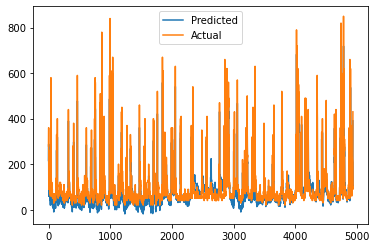

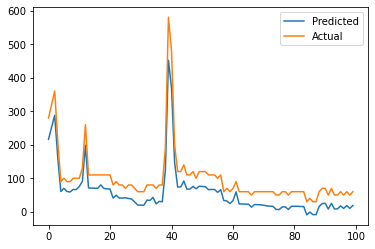

In [12]:
import matplotlib.pyplot as plt
plt.plot(yhat,label='Predicted')
plt.plot(y,label='Actual')
plt.legend()
plt.show()


plt.plot(yhat[0:100],label='Predicted')
plt.plot(y[0:100],label='Actual')
plt.legend()
plt.show()


In [13]:
scaler.inverse_transform(model(test_norm).detach().numpy())

array([[216.20432  ,  -1.8137852,  24.33697  , ...,   5.7604837,
         44.569912 ,   6.7993975],
       [252.46692  ,  -1.7803472,  24.388113 , ...,   5.6194644,
         43.855312 ,   6.607758 ],
       [287.68246  ,  -1.777068 ,  24.421696 , ...,   5.613242 ,
         43.473446 ,   6.4559755],
       ...,
       [259.38235  ,   3.0357773,  26.250933 , ...,   4.4268255,
         24.073765 ,  12.486752 ],
       [384.47433  ,   3.257782 ,  26.206928 , ...,   4.647847 ,
         24.219162 ,  12.606931 ],
       [390.4704   ,   3.387919 ,  26.149094 , ...,   4.733685 ,
         25.201145 ,  12.419148 ]], dtype=float32)

In [14]:
model(test_norm).detach().numpy().shape

(4934, 26)

In [15]:
#forecast_df = pd.DataFrame(scaler.inverse_transform(model(test_norm).detach().numpy()),columns=list(data_test.columns))

In [16]:
#forecast_df

In [17]:
data_test

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
14801,280,0,22.390000,37.930000,22.390000,35.400000,24.430000,35.723333,22.5,34.790000,...,23.456000,38.378000,20.79,39.296667,8.450000,756.933333,62.833333,5.166667,40.000000,1.716667
14802,320,0,22.390000,37.863333,22.356667,35.290000,24.860000,36.133333,22.5,34.700000,...,23.500000,38.264286,20.79,38.963333,8.500000,757.000000,62.000000,5.000000,40.000000,1.600000
14803,360,0,22.390000,37.790000,22.290000,35.290000,25.172500,36.675000,22.5,34.700000,...,23.500000,38.090000,20.79,38.826667,8.500000,757.000000,61.666667,5.000000,40.000000,1.516667
14804,210,0,22.390000,37.790000,22.230000,35.200000,25.430000,36.900000,22.5,34.700000,...,23.557143,37.998571,20.79,38.966667,8.500000,757.000000,61.333333,5.000000,40.000000,1.433333
14805,90,0,22.426667,39.100000,22.290000,35.460000,25.633333,36.900000,22.5,34.700000,...,23.600000,37.860000,20.79,39.000000,8.500000,757.000000,61.000000,5.000000,40.000000,1.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,24.700000,50.074000,23.20,46.790000,22.733333,755.200000,55.666667,3.333333,23.666667,13.333333
19731,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,24.700000,49.790000,23.20,46.790000,22.600000,755.200000,56.000000,3.500000,24.500000,13.300000
19732,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,24.700000,49.660000,23.20,46.790000,22.466667,755.200000,56.333333,3.666667,25.333333,13.266667
19733,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,24.662500,49.518750,23.20,46.817500,22.333333,755.200000,56.666667,3.833333,26.166667,13.233333


Appliances
RMSE:  30.496291131043996
R2:  0.8806720861292541
MAE:  24.93260026933421


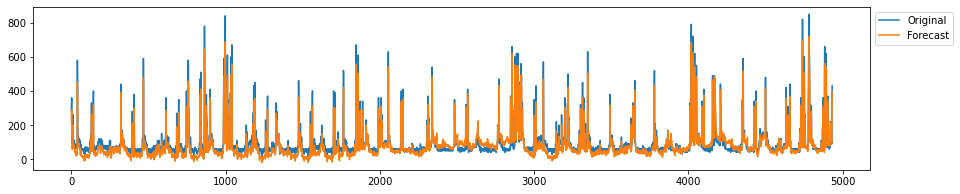


lights
RMSE:  3.33434917700623
R2:  0.6392906274443475
MAE:  2.896904661927614


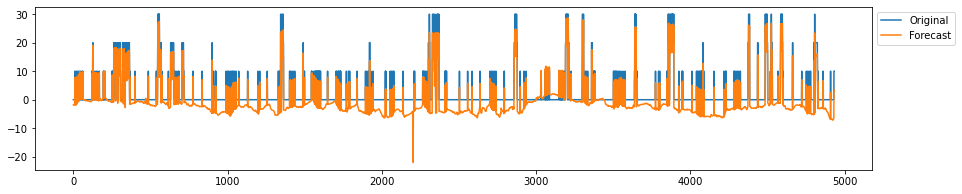


T1
RMSE:  1.9745345661532638
R2:  -0.8486616589374281
MAE:  1.508634146814201


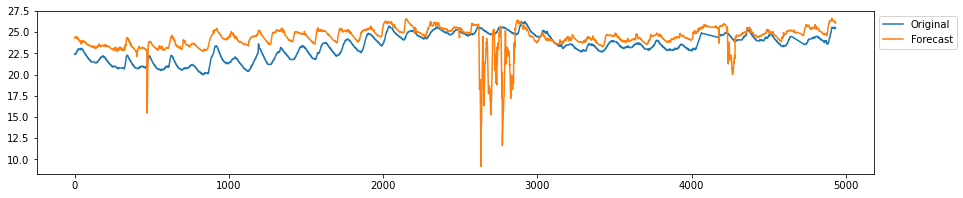


RH_1
RMSE:  5.449464520411481
R2:  -0.17666064742291132
MAE:  4.886983408072948


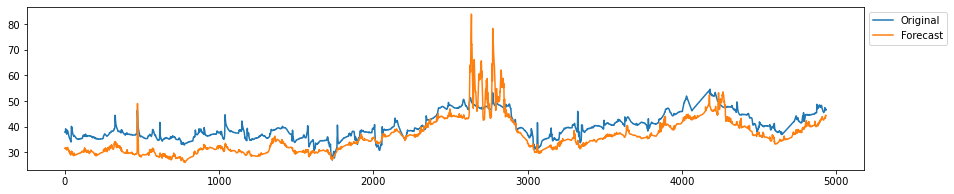


T2
RMSE:  2.802807317625217
R2:  -0.19097219417565792
MAE:  1.58859952253247


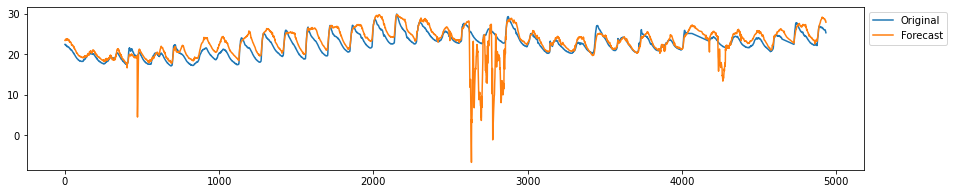


RH_2
RMSE:  8.052380135126935
R2:  -1.1116525339534888
MAE:  4.986165065615096


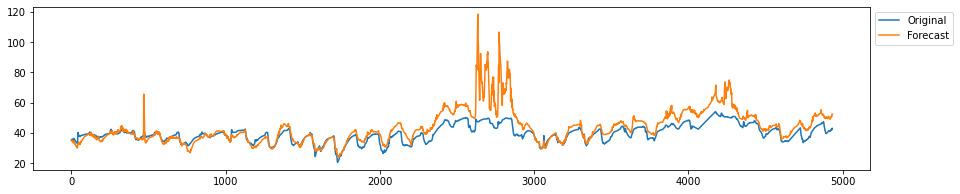


T3
RMSE:  2.1335149653849386
R2:  -0.6217799219553151
MAE:  1.949669404009837


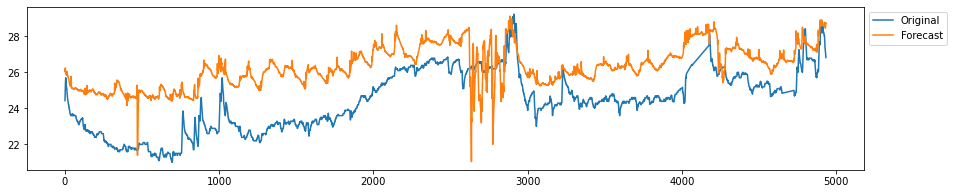


RH_3
RMSE:  3.911752605946094
R2:  -0.3156906147324421
MAE:  3.379048767070699


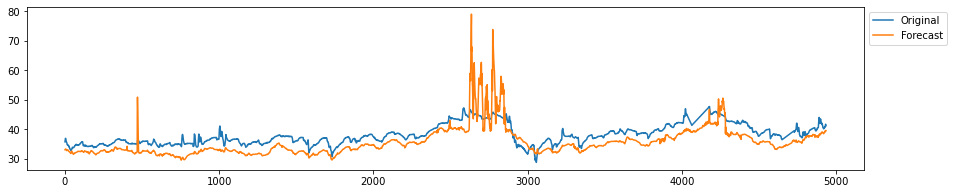


T4
RMSE:  0.5214822382048877
R2:  0.9091379505716484
MAE:  0.4134693228417773


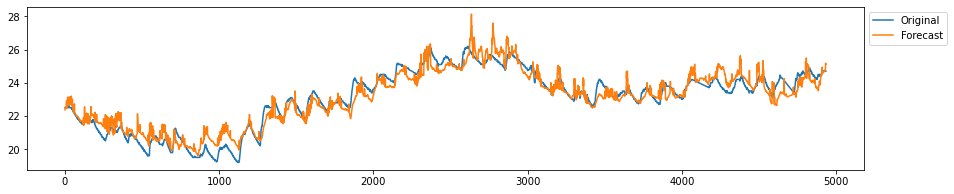


RH_4
RMSE:  2.0134540091900983
R2:  0.8075045591890901
MAE:  1.4499167502301158


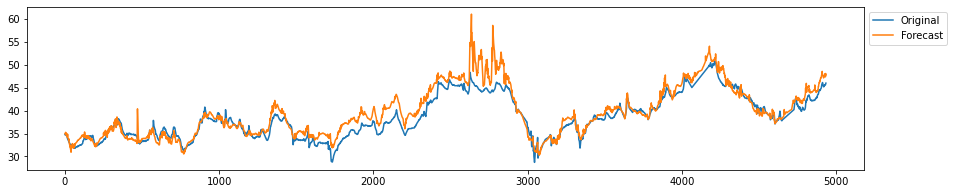


T5
RMSE:  2.238343590937133
R2:  -0.7011747435347591
MAE:  2.061675224182317


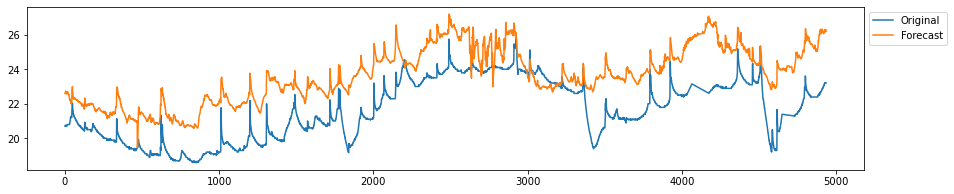


RH_5
RMSE:  4.881582709362571
R2:  0.6943336977678631
MAE:  3.9423090782742087


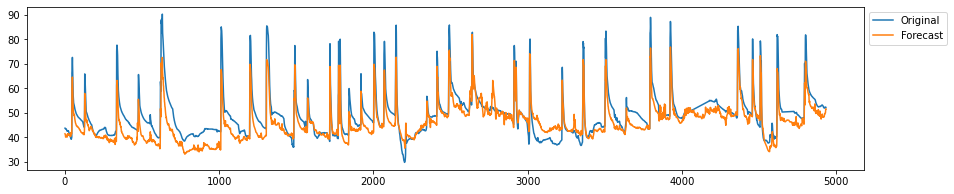


T6
RMSE:  8.341700254896216
R2:  -0.5498544544387545
MAE:  4.4268791595163055


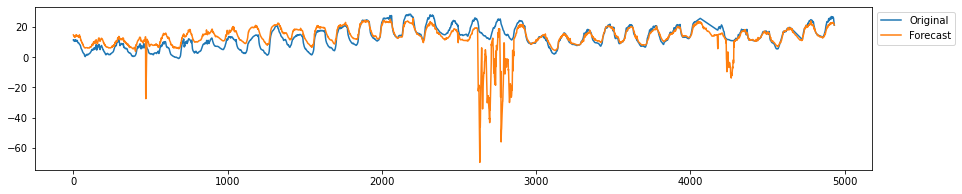


RH_6
RMSE:  17.386938840709558
R2:  0.2925866960436555
MAE:  11.809595747101728


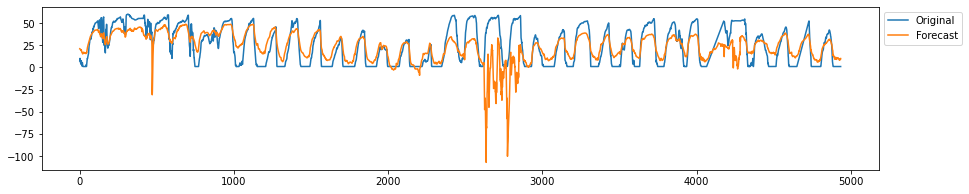


T7
RMSE:  1.0394104833232245
R2:  0.6653587706824955
MAE:  0.8697645371315379


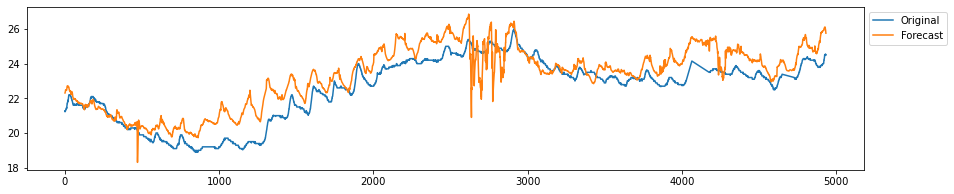


RH_7
RMSE:  2.1604647187045964
R2:  0.8368861373873544
MAE:  1.741438641549161


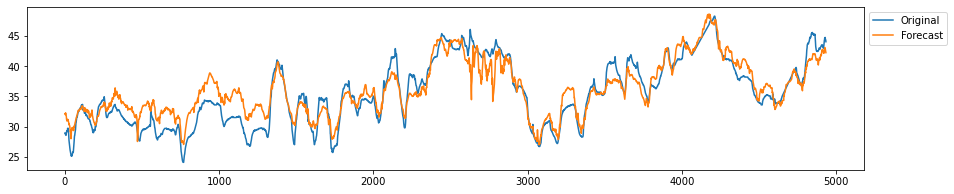


T8
RMSE:  1.059814084858923
R2:  0.3988855518958555
MAE:  0.8925111181829323


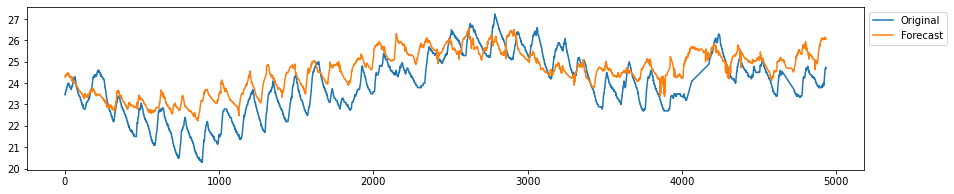


RH_8
RMSE:  4.253282505573959
R2:  0.3032101577013937
MAE:  3.7011163114379064


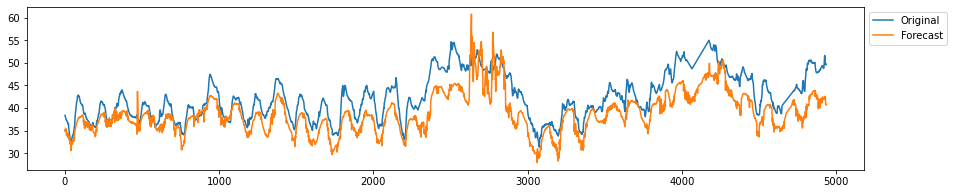


T9
RMSE:  1.9728827398864301
R2:  -0.35276161272025885
MAE:  1.7162098790639757


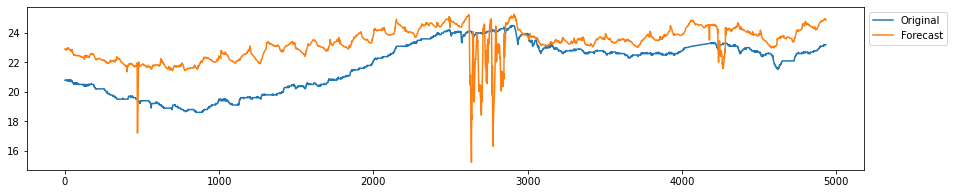


RH_9
RMSE:  3.2718339190931265
R2:  0.5123433978568512
MAE:  1.9111938938006394


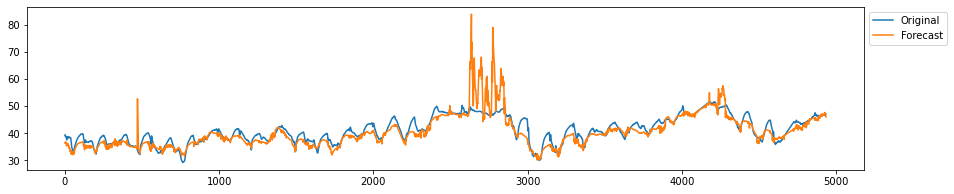


T_out
RMSE:  7.977160384582527
R2:  -0.929145020593827
MAE:  4.080214800013245


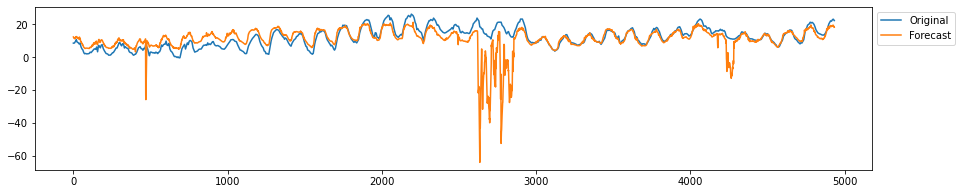


Press_mm_hg
RMSE:  6.076259849879914
R2:  -0.3137355905426644
MAE:  4.17291717357487


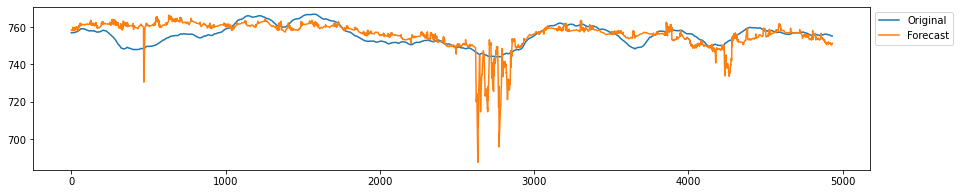


RH_out
RMSE:  23.06403374153614
R2:  -0.5935431040694203
MAE:  14.602577037157971


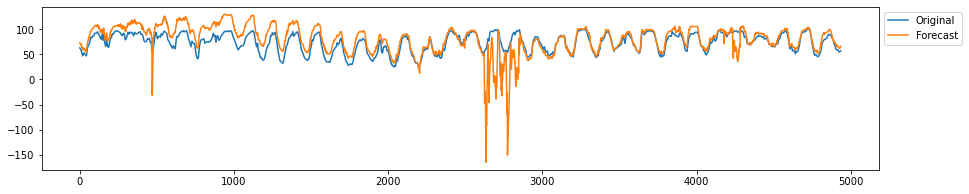


Windspeed
RMSE:  0.9960491403861607
R2:  0.6671165719098786
MAE:  0.8992864215330504


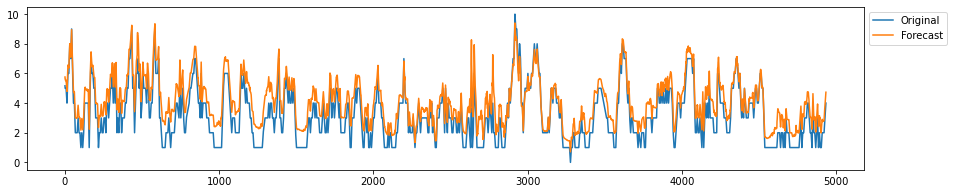


Visibility
RMSE:  11.125431036065917
R2:  -0.663755580332509
MAE:  6.114884547004344


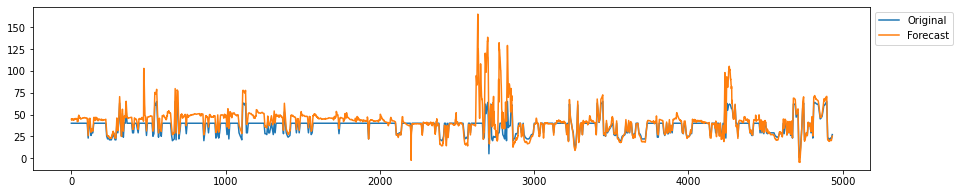


Tdewpoint
RMSE:  9.201578696164761
R2:  -3.1516378875217033
MAE:  4.773385210084888


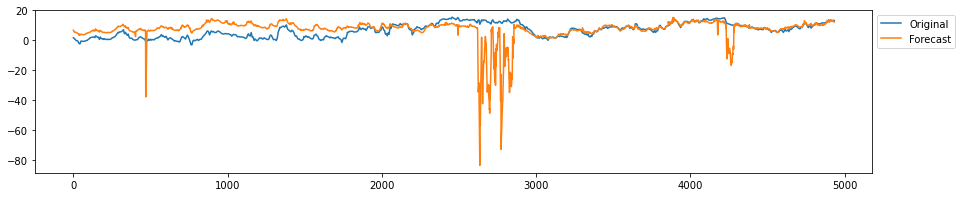

In [18]:
forecast_df = pd.DataFrame(scaler.inverse_transform(model(test_norm).detach().numpy()),columns=list(data_test.columns))

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
 
# original = original[:len(original)-1]
# forecast = forecast[1:]  

validation_df = data_test
    
for index,i in enumerate(validation_df.columns):
    print(i)
    
    original = validation_df[i].values
    forecast = forecast_df[i].values

    print("RMSE: ",mean_squared_error(original,forecast,squared=False),end="\n")
    print("R2: ",r2_score(original,forecast),end="\n")
    print("MAE: ",mean_absolute_error(original,forecast),end="\n")
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
    ax.plot(original, label='Original')
    ax.plot(forecast, label='Forecast')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
    plt.show()
    
    print()